In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 读取两个CSV文件
mod_df = pd.read_csv('特征和密度结果_MODIS_MOD09GA_061_20241029_插值填充3.csv')
mcd_df = pd.read_csv('特征和密度结果_MODIS_MCD18C2_061_20241027_插值填充.csv')

# 重命名MCD数据框中的密度列,以区分来源
mcd_df = mcd_df.rename(columns={
    'density_mean': 'density_mean_mcd',
    'density_lower': 'density_lower_mcd', 
    'density_upper': 'density_upper_mcd'
})

# 重命名MOD数据框中的密度列
mod_df = mod_df.rename(columns={
    'density_mean': 'density_mean_mod',
    'density_lower': 'density_lower_mod',
    'density_upper': 'density_upper_mod'
})

# 合并两个数据框,以date为键
merged_df = pd.merge(mod_df, mcd_df, on='date')

# 计算两个来源的平均值作为最终密度值
merged_df['density_mean'] = merged_df['density_mean_mod']
merged_df['density_lower'] = merged_df['density_lower_mod']
merged_df['density_upper'] = merged_df['density_upper_mod']


## 模型4.0版本（增加卷积核遍历）



让我分析一下为什么TCN模型预测的数据波动较大而LSTM模型预测的数据波动较小。



主要原因可以从以下几个方面分析：

1. 模型架构特性差异：
- LSTM模型通过门控机制和内部状态可以较好地记忆长期依赖关系，能够平滑地处理时序数据
- TCN模型基于卷积运算，更容易捕捉局部特征和突变，对短期变化更敏感

2. 数据预处理差异：
- LSTM模型使用了StandardScaler进行数据标准化，这有助于平滑数据分布
- TCN模型没有进行数据标准化，使得模型可能对原始数据的波动更敏感

3. 损失函数差异：
- LSTM使用了Huber损失函数，对异常值更具鲁棒性，有助于产生更平滑的预测
- TCN使用了MSE损失函数，可能对异常值更敏感，导致预测结果波动更大

4. 网络结构参数差异：
- LSTM模型使用了较多的BatchNormalization层和Dropout层，这些正则化技术有助于产生更稳定的预测
- TCN模型虽然也使用了LayerNormalization和Dropout，但扩张卷积的特性可能导致对输入变化更敏感

建议改进方案：

1. 对TCN模型：
```python
# 添加数据标准化
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
```

2. 考虑修改TCN的损失函数：
```python
model.compile(optimizer=optimizer, loss='huber')  # 改用Huber损失
```

3. 调整TCN的网络结构：
- 减小扩张率的增长速度
- 增加残差块中的正则化强度
- 考虑添加更多的平滑层

4. 针对LSTM模型的波动过小：
- 可以适当减少BatchNormalization层的使用
- 降低Dropout比例
- 考虑增加学习率

这样的调整应该能帮助两个模型达到更好的平衡，既不会波动过大也不会过于平滑。

In [2]:
# 将日期列转换为datetime类型
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 定义重要特征列
important_features = ['GMT_0900_PAR', 'GMT_0600_PAR', 'GMT_0300_PAR',  'GMT_0000_PAR','FAI', 'ndvi', 'nrfi', 
                     'MPAR', 'PDVI', 'DAPAR', 'PPDI']

# 按日期划分训练集和测试集
train_df = merged_df[merged_df['date'] <= '2023-12-31']
test_df = merged_df[merged_df['date'] >= '2024-01-01']

# 准备序列数据,考虑15天的时间滞后效应
def create_sequences(data, features, seq_length=15):
    X, y = [], []
    feature_data = data[features].values
    target_data = data[['density_mean', 'density_lower', 'density_upper']].values
    
    for i in range(len(data) - seq_length):
        X.append(feature_data[i:(i + seq_length)])
        y.append(target_data[i + seq_length])
    return np.array(X), np.array(y)

# 数据标准化
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 准备训练集和测试集序列数据
seq_length = 15  # 使用15天的序列长度
X_train, y_train = create_sequences(train_df, important_features, seq_length)
X_test, y_test = create_sequences(test_df, important_features, seq_length)

# 对特征进行标准化
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

# 对目标变量进行标准化
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 导入必要的库
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model

# 构建改进的LSTM模型
def build_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    
    # 第一个LSTM层 - 减少BatchNormalization使用
    x = LSTM(256, return_sequences=True)(input_layer)
    x = Dropout(0.2)(x)  # 降低Dropout比例
    
    # 第二个LSTM层
    x = LSTM(128, return_sequences=True)(x)
    x = BatchNormalization()(x)  # 只在中间层使用BatchNormalization
    x = Dropout(0.2)(x)
    
    # 第三个LSTM层
    x = LSTM(64)(x)
    x = Dropout(0.2)(x)
    
    # 全连接层 - 简化结构
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    
    # 输出层
    output_layer = Dense(3, activation='linear')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# 构建和编译模型
model = build_lstm_model((seq_length, len(important_features)))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # 增加学习率
model.compile(optimizer=optimizer, loss='huber')  # 保持Huber损失函数

# 设置回调函数
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # 减少耐心值以允许更多波动
    restore_best_weights=True,
    min_delta=1e-4
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # 更温和的学习率衰减
    patience=10,
    min_lr=1e-5,
    verbose=1
)

# 训练模型
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=500,
    batch_size=64,  # 减小批次大小以增加随机性
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 使用模型进行预测并反标准化
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

y_mean_pred = predictions[:, 0]
y_lower_pred = predictions[:, 1]
y_upper_pred = predictions[:, 2]


2024-10-31 15:41:03.576800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 15:41:03.603266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 15:41:03.633056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 15:41:03.640128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 15:41:03.668671: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.2453 - val_loss: 0.3675 - learning_rate: 0.0010
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.1888 - val_loss: 0.3893 - learning_rate: 0.0010
Epoch 3/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.1941 - val_loss: 0.4397 - learning_rate: 0.0010
Epoch 4/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.1899 - val_loss: 0.4595 - learning_rate: 0.0010
Epoch 5/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.1531 - val_loss: 0.4720 - learning_rate: 0.0010
Epoch 6/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.1517 - val_loss: 0.4881 - learning_rate: 0.0010
Epoch 7/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.1440 - val_loss: 0.5816 - learning_rate: 0.0010
Epoch 8/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.1579 - val_loss: 0.5366 - learning_rate: 0.0010
Epoch 9/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.1267 - val_loss: 0.5816 - learning_rate: 0.0010
Epoch 10/

/tmp/ipykernel_19745/3724871750.py:23: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/3724871750.py:23: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/3724871750.py:23: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/3724871750.py:23: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/3724871750.py:23: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/3724871750.py:23: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/3724871750.py:23: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  plt.

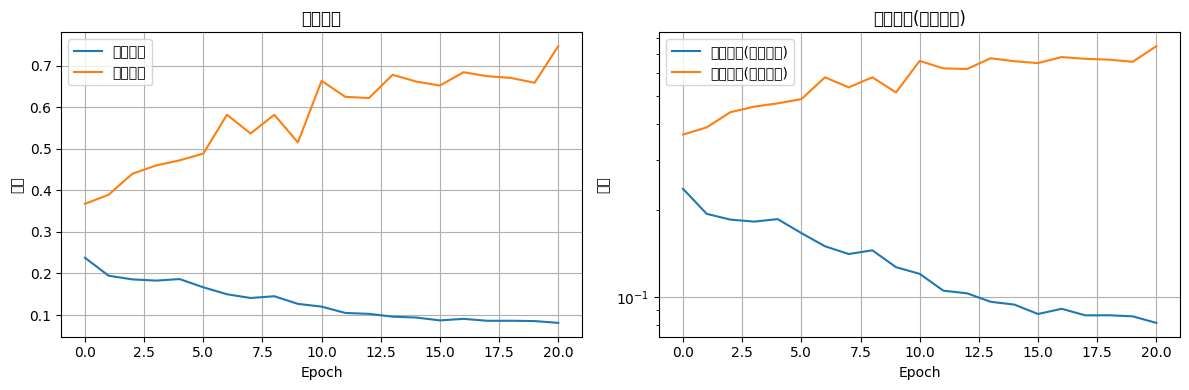


最终训练损失: 0.081163
最终验证损失: 0.746566
最佳验证损失: 0.367455


In [3]:

# 绘制训练历史
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('模型损失')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='训练损失(对数尺度)')
plt.plot(history.history['val_loss'], label='验证损失(对数尺度)')
plt.yscale('log')
plt.title('模型损失(对数尺度)')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 打印最终的训练和验证损失
print(f"\n最终训练损失: {history.history['loss'][-1]:.6f}")
print(f"最终验证损失: {history.history['val_loss'][-1]:.6f}")
print(f"最佳验证损失: {min(history.history['val_loss']):.6f}")



R2 分数:
平均密度: -1.3322
下限密度: -1.3203
上限密度: -1.4741


/tmp/ipykernel_19745/891806621.py:38: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/891806621.py:38: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/891806621.py:38: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/891806621.py:38: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/891806621.py:38: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/891806621.py:38: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19745/891806621.py:38: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_l

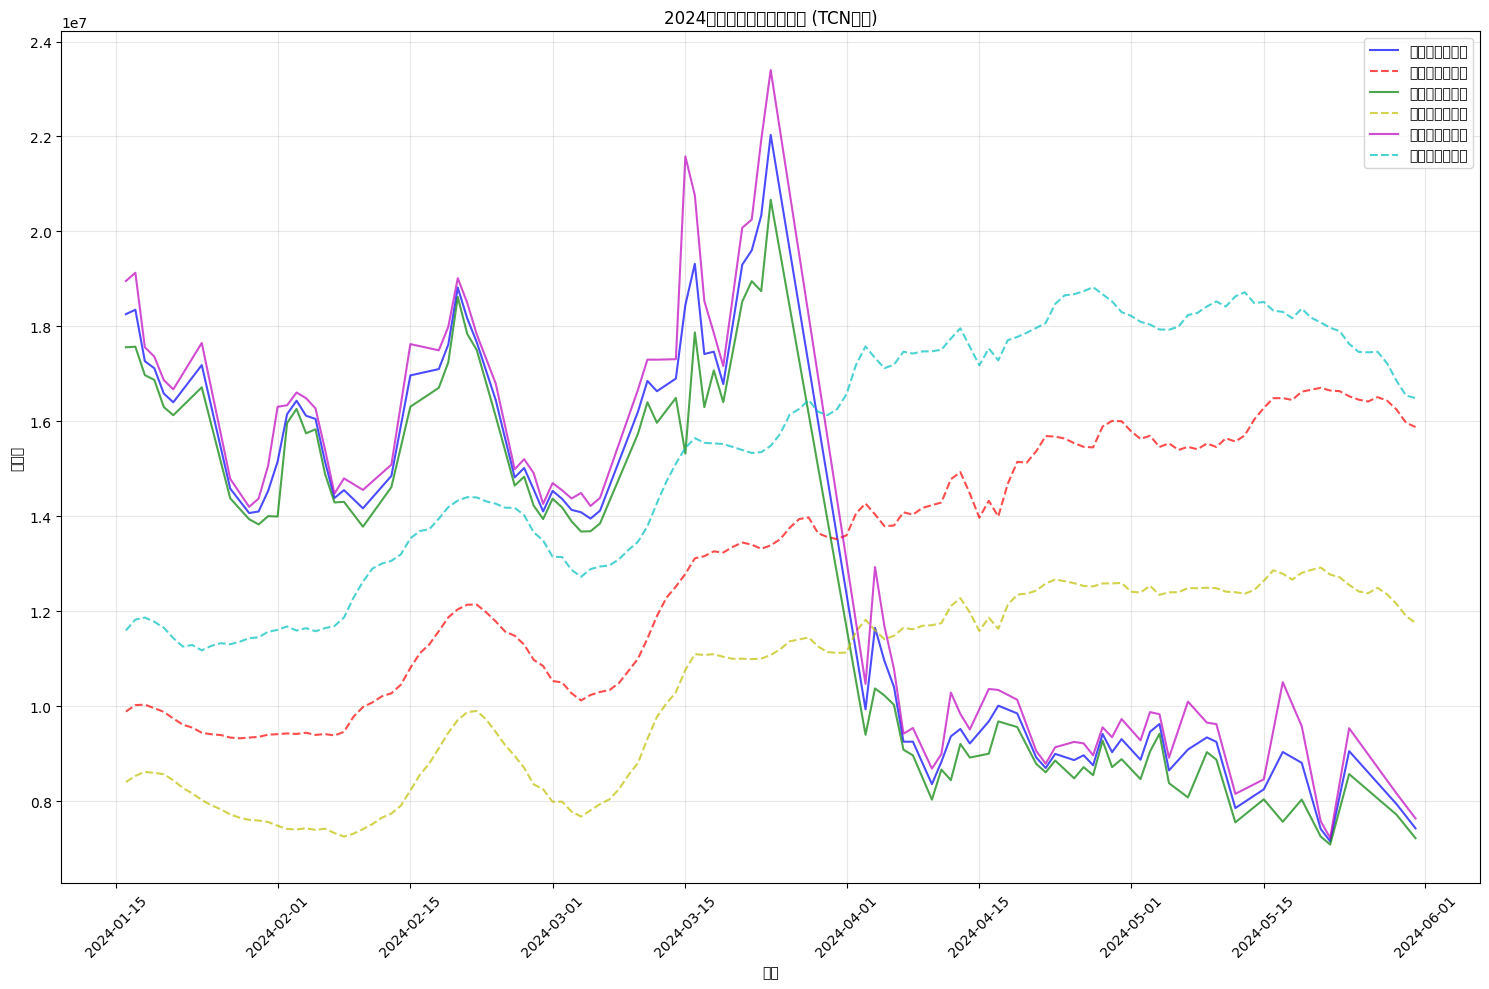

In [4]:

# 计算R2分数
r2_mean = r2_score(y_test[:, 0], y_mean_pred)
r2_lower = r2_score(y_test[:, 1], y_lower_pred)
r2_upper = r2_score(y_test[:, 2], y_upper_pred)

print("\nR2 分数:")
print(f"平均密度: {r2_mean:.4f}")
print(f"下限密度: {r2_lower:.4f}")
print(f"上限密度: {r2_upper:.4f}")

# 绘制测试集的预测结果
plt.figure(figsize=(15, 10))

# 调整日期索引以匹配序列预测结果
test_dates = test_df['date'].iloc[seq_length:]

# 绘制实际值和预测值
plt.plot(test_dates, y_test[:, 0], 'b-', label='平均密度实际值', alpha=0.7)
plt.plot(test_dates, y_mean_pred, 'r--', label='平均密度预测值', alpha=0.7)
plt.plot(test_dates, y_test[:, 1], 'g-', label='下限密度实际值', alpha=0.7)
plt.plot(test_dates, y_lower_pred, 'y--', label='下限密度预测值', alpha=0.7)
plt.plot(test_dates, y_test[:, 2], 'm-', label='上限密度实际值', alpha=0.7)
plt.plot(test_dates, y_upper_pred, 'c--', label='上限密度预测值', alpha=0.7)

# 添加标题和标签
plt.title('2024年藻密度预测结果对比 (TCN模型)')
plt.xlabel('日期')
plt.ylabel('藻密度')
plt.legend()

# 旋转x轴日期标签以提高可读性
plt.xticks(rotation=45)

# 显示网格
plt.grid(True, alpha=0.3)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()